# Cas Kaggle - Predicció obessitat
https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster/data

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error



### Descripció de les variables
- Frequent consumption of high caloric food (FAVC)
- Frequency of consumption of vegetables (FCVC) 
- Number of main meals (NCP)
- Consumption of food between meals (CAEC)
- Consumption of water daily (CH20)
- Consumption of alcohol (CALC). 
- Calories consumption monitoring (SCC)
- Physical activity frequency (FAF)
- Time using technology devices (TUE)
- Transportation used (MTRANS)

## Dividir training i test

In [3]:
# Carregar el CSV en un DataFrame
df_full = pd.read_csv("ObesityDataSet.csv", encoding="utf-8")

# Mostrar les primeres files
df_full



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [4]:
# Dividir les dades en train i test
X = df_full[[col for col in df_full.columns if col != 'NObeyesdad']]
y = df_full['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

y_train

1994       Obesity_Type_III
17           Obesity_Type_I
206          Obesity_Type_I
1944       Obesity_Type_III
1198    Overweight_Level_II
               ...         
1560        Obesity_Type_II
162           Normal_Weight
609     Insufficient_Weight
1718        Obesity_Type_II
470           Normal_Weight
Name: NObeyesdad, Length: 1794, dtype: object

## Explortory data analysis

In [5]:
df_split = pd.concat([X_train, y_train], axis=1)
df_split


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1994,Female,21.282238,1.748951,133.662583,yes,yes,3.000000,3.000000,Sometimes,no,2.247979,no,1.609938,0.849236,Sometimes,Public_Transportation,Obesity_Type_III
17,Female,29.000000,1.530000,78.000000,no,yes,2.000000,1.000000,Sometimes,no,2.000000,no,0.000000,0.000000,no,Automobile,Obesity_Type_I
206,Male,19.000000,1.750000,100.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,2.000000,0.000000,no,Public_Transportation,Obesity_Type_I
1944,Female,21.051982,1.729719,131.877558,yes,yes,3.000000,3.000000,Sometimes,no,1.422483,no,1.708971,0.673009,Sometimes,Public_Transportation,Obesity_Type_III
1198,Male,18.000000,1.750097,86.372141,yes,yes,2.907062,3.000000,Sometimes,no,2.740848,no,1.219827,0.037634,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,Male,25.300208,1.765258,114.330023,yes,yes,1.562804,3.000000,Sometimes,no,2.075493,no,1.553734,0.000436,Sometimes,Public_Transportation,Obesity_Type_II
162,Female,21.000000,1.630000,60.000000,yes,yes,3.000000,3.000000,Always,yes,2.000000,no,2.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
609,Male,19.979810,1.753360,54.997374,yes,yes,2.000000,3.494849,Sometimes,no,2.976672,no,1.949070,2.000000,no,Public_Transportation,Insufficient_Weight
1718,Male,25.879411,1.765464,114.144378,yes,yes,1.626369,3.000000,Sometimes,no,2.109697,no,1.352973,0.076693,Sometimes,Public_Transportation,Obesity_Type_II


In [6]:
print(df_split.describe())

               Age       Height       Weight         FCVC          NCP  \
count  1794.000000  1794.000000  1794.000000  1794.000000  1794.000000   
mean     24.283944     1.702314    86.580621     2.426377     2.682923   
std       6.339740     0.093515    25.997022     0.529187     0.777583   
min      14.000000     1.456346    39.000000     1.000000     1.000000   
25%      19.899719     1.629550    65.934516     2.000000     2.656871   
50%      22.762612     1.701609    83.231077     2.398408     3.000000   
75%      26.000000     1.770000   107.087496     3.000000     3.000000   
max      61.000000     1.980000   160.639405     3.000000     4.000000   

              CH2O          FAF          TUE  
count  1794.000000  1794.000000  1794.000000  
mean      2.016808     1.016984     0.652431  
std       0.612781     0.845354     0.601616  
min       1.000000     0.000000     0.000000  
25%       1.607680     0.131685     0.000000  
50%       2.000000     1.000000     0.619850  
75% 

In [7]:
print("Número d'atributs del dataset:", len(df_split.keys()))
print("Número de files en el train (mostres): ",df_split.shape[0])

Número d'atributs del dataset: 17
Número de files en el train (mostres):  1794


In [8]:
# Mirem valors NaN per atribut
nan_counts = df_split.isna().sum()
var_type = df_split.dtypes
# Mostrem una taula amb els valors NaN i el tipus de variable
print("Valors NaN per atribut i tipus de variable:")
print(pd.DataFrame({"NaN Count": nan_counts, "Variable Type": var_type}))

Valors NaN per atribut i tipus de variable:
                                NaN Count Variable Type
Gender                                  0        object
Age                                     0       float64
Height                                  0       float64
Weight                                  0       float64
family_history_with_overweight          0        object
FAVC                                    0        object
FCVC                                    0       float64
NCP                                     0       float64
CAEC                                    0        object
SMOKE                                   0        object
CH2O                                    0       float64
SCC                                     0        object
FAF                                     0       float64
TUE                                     0       float64
CALC                                    0        object
MTRANS                                  0        object
NObe

No hi ha NANS.

Variables catagòriques:
- Gènere (dona/home) --> binaria
- Historial familiar (si/no) --> binaria
- consum freq d'aliments en calories FAVC (si/no) --> binaria
- Freq de menjar amb carn CAEC (sempre,freqüent, a vegades,no) --> ordinal
- Fumar(sí/no) --> binaria
- Monitorització consum de calories SCC (sí/no) --> binaria
- Consum d'alcohol CALC (sempre,freqüent, a vegades,no) --> ordinal
- Transport (automobil, moto, trans public, caminar, bici)
- Tipus d'obestitat (obesitat tipus 1/2, sobrepres 1/2, pes normal, pes insuficient) --> ordinal

Variables númeriques:
- Edat
- Alçada
- Pes
- Frequencia del consum de verdures (FCVC)
- Número de carns NCP
- Consum d'aigua CH20
- Freq d'activitat física FAF
- Temps d'ús disp tecno TUE


c:\Users\natal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\natal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\natal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\natal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

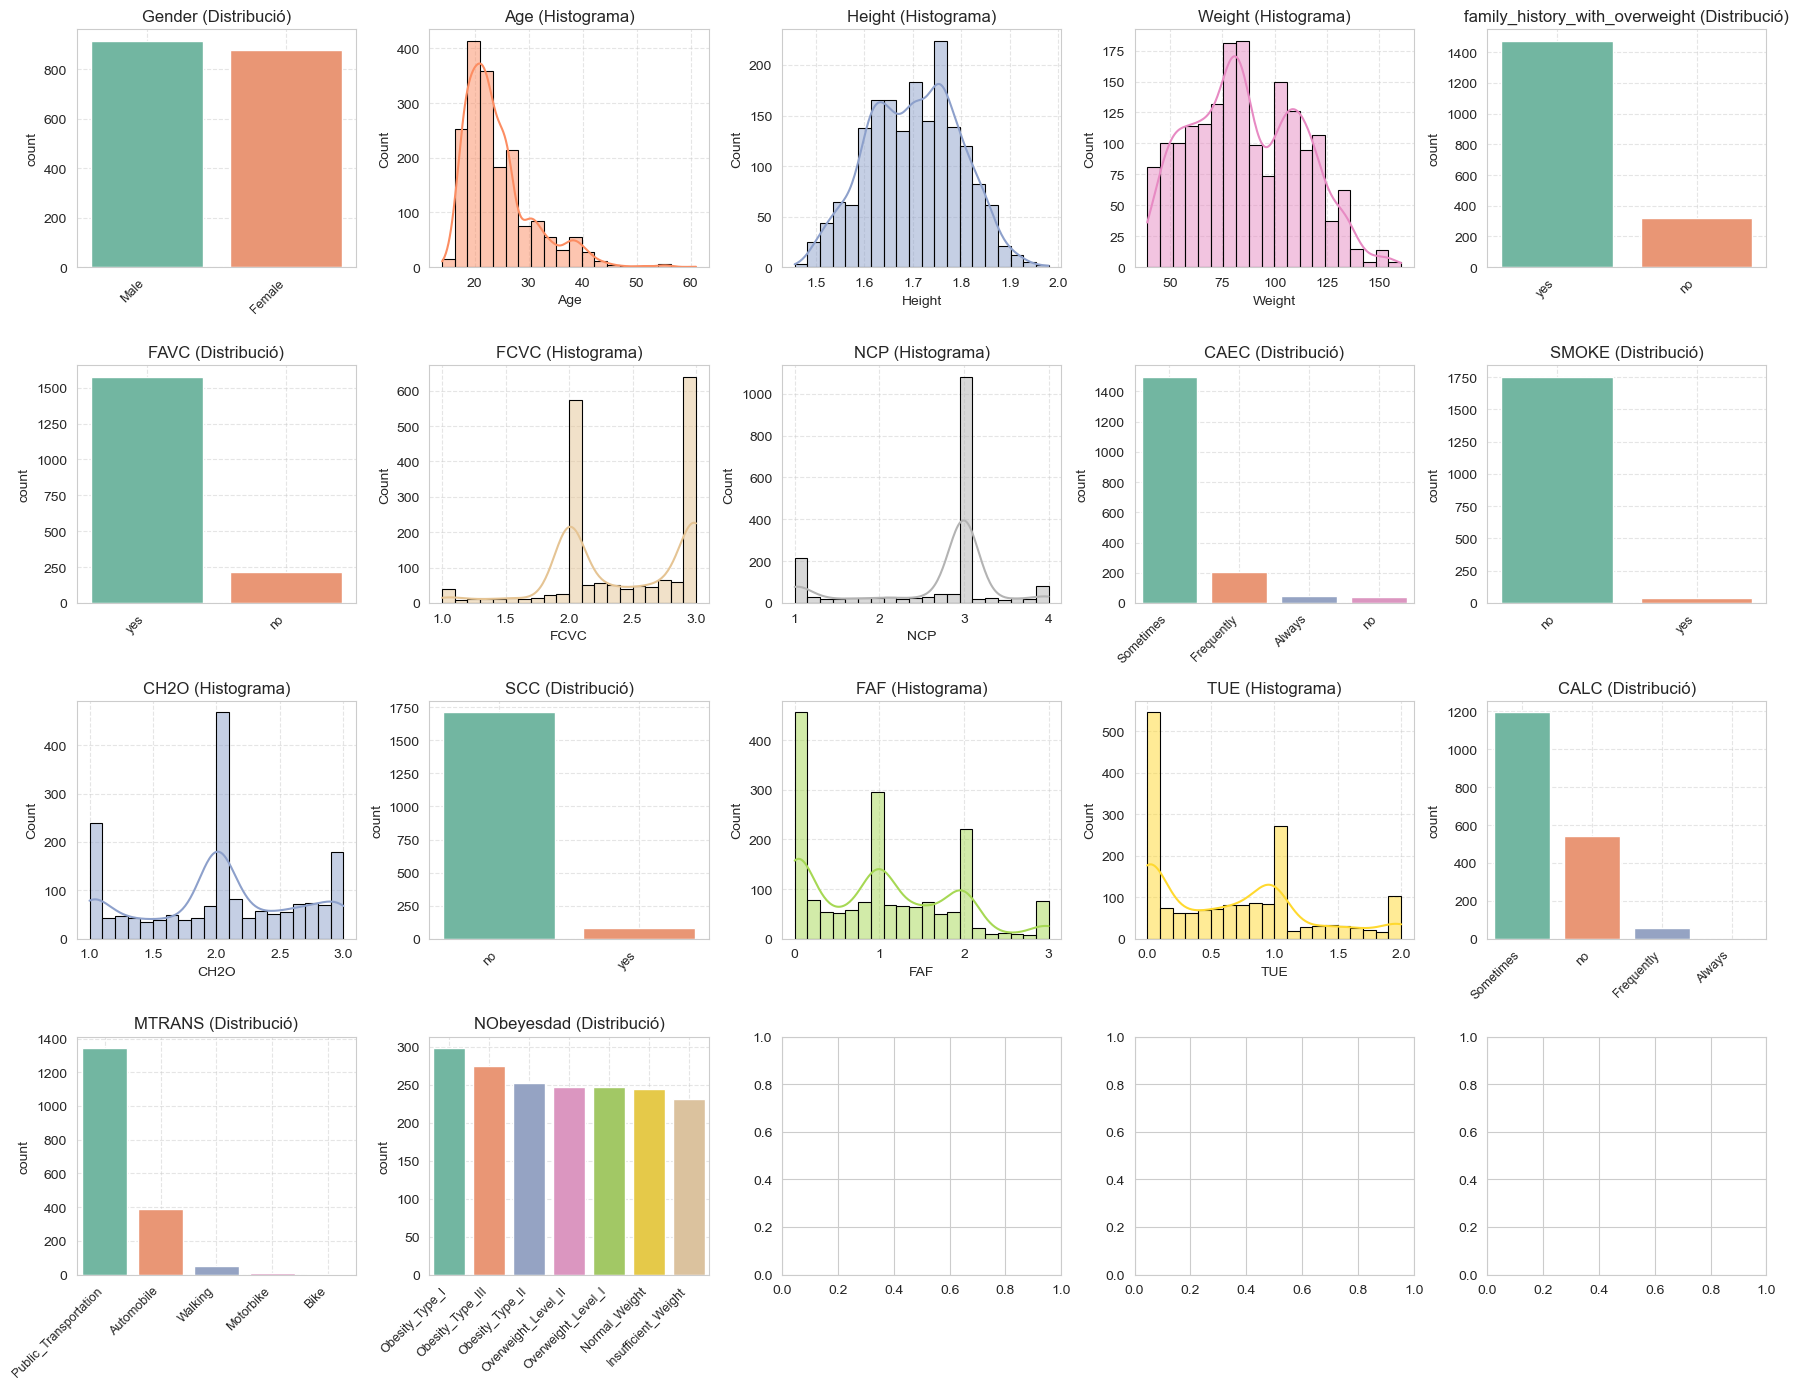

In [9]:
cols = df_split.columns.tolist()

sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(4, 5, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(cols[:17]): 
    ax = axes[i]
    
    if (not pd.api.types.is_numeric_dtype(df_split[col])) or (df_split[col].nunique() <= 6):
        sns.countplot(
            x=df_split[col], 
            ax=ax, 
            order=df_split[col].value_counts().index, 
            palette=palette
        )
        ax.set_title(f'{col} (Distribució)')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

    else:
        sns.histplot(
            data=df_split, 
            x=col, 
            bins=20, 
            kde=True, # Afegim suavització (KDE)
            color=palette[i % len(palette)], # Assigna un color de la paleta
            edgecolor='black',
            ax=ax
        )
        ax.set_title(f'{col} (Histograma)', fontsize=12)
        ax.set_xlabel(col, fontsize=10)

    
    
    ax.grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, 17):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

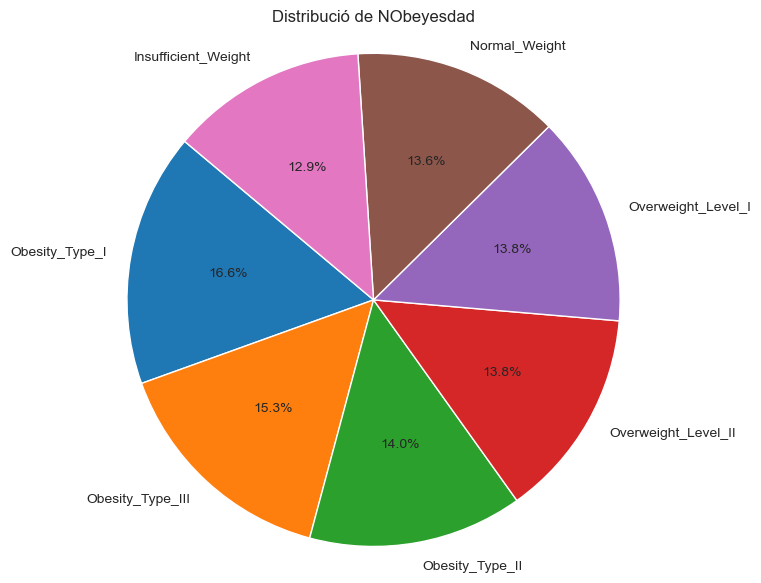

In [10]:
import matplotlib.pyplot as plt

counts = df_split['NObeyesdad'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribució de NObeyesdad')
plt.axis('equal')
plt.show()

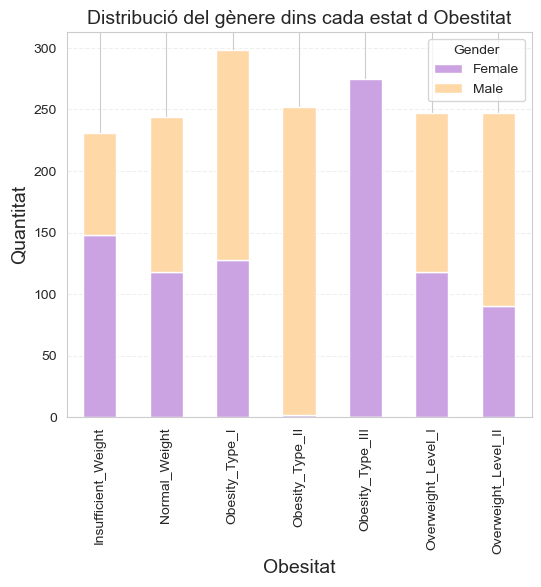

In [11]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split['Gender']) 

ct_rev.plot(kind='bar', stacked=True, 
            color=['#CBA3E3', '#FFD8A8'], 
            figsize=(6,5))

plt.title('Distribució del gènere dins cada estat d Obestitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

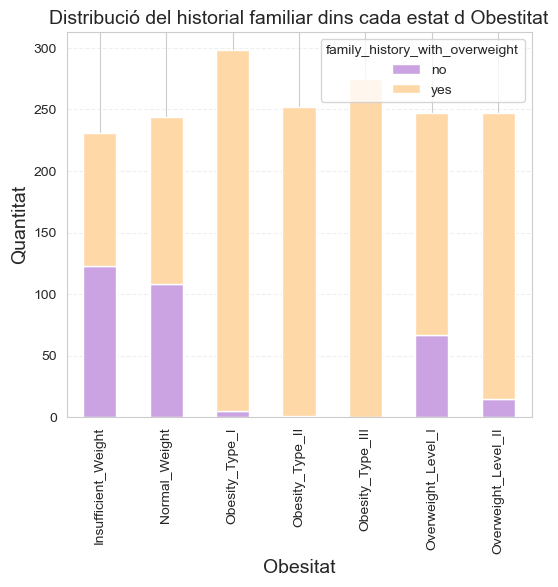

In [12]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split["family_history_with_overweight"]) 

ct_rev.plot(kind='bar', stacked=True, 
            color=['#CBA3E3', '#FFD8A8'], 
            figsize=(6,5))

plt.title('Distribució del historial familiar dins cada estat d Obestitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

In [ ]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split['CAEC'] ) 

ct_rev.plot(kind='bar', stacked=True, color=['#CBA3E3', '#FFD8A8', '#A8E6CF',"#DE8689"],
            figsize=(6,5))

plt.title('Distribució de la freq de menjar carn dins cada estat d Obesitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

Comentem algo

Mirem si hi ha outliers

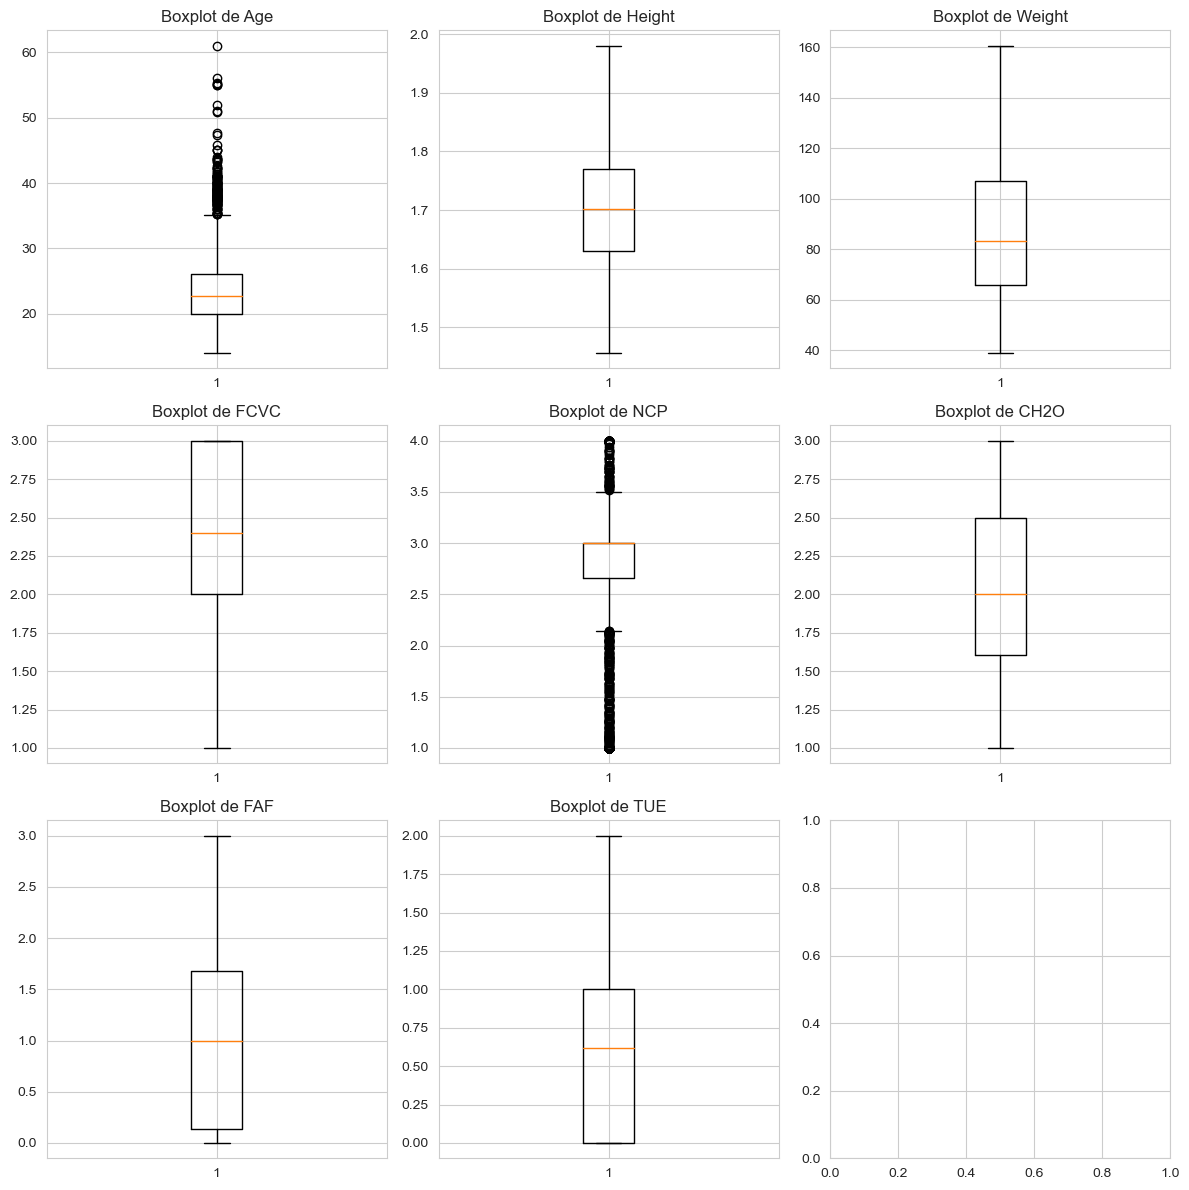

In [13]:
# Seleccionem només les variables numèriques
numeriques = df_split.select_dtypes(include=['float64', 'int64']).columns

# Definim la quadrícula 3x2
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3 files, 2 columnes
axes = axes.flatten()  # convertim a array 1D per iterar més fàcil

# Fem el boxplot per cada variable
for i, col in enumerate(numeriques[:8]):  # Només 6 variables per a 3x2
    axes[i].boxplot(df_split[col])
    axes[i].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

No veiem cap boxplot amb outliers importants, la variable NPC està entre valors del 0 al 4 i age entre 14 i 61. Però al normalitzar utilitzarem el z-score.

In [14]:
df_split = pd.get_dummies(df_split, columns=['MTRANS'])
df_split.head()

bool_cols = df_split.select_dtypes(include='bool').columns
df_split[bool_cols] = df_split[bool_cols].astype(int)

In [15]:
df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df_split['FAVC'] = df_split['FAVC'].replace({'yes': 1, 'no': 0})
df_split['SMOKE'] = df_split['SMOKE'].replace({'yes': 1, 'no': 0})
df_split['SCC'] = df_split['SCC'].replace({'yes': 1, 'no': 0})
df_split['CALC'] = df_split['CALC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})
df_split['CAEC'] = df_split['CAEC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})

C:\Users\natal\AppData\Local\Temp\ipykernel_32452\632722537.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\natal\AppData\Local\Temp\ipykernel_32452\632722537.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
C:\Users\natal\AppData\Local\Temp\ipykernel_32452\632722537.py:3: FutureWarning: Downcasting behavior in `replace` is dep

In [16]:
df_split.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
1994,0,21.282238,1.748951,133.662583,1,1,3.000000,3.0,1,0,...,0,1.609938,0.849236,1,Obesity_Type_III,0,0,0,1,0
17,0,29.000000,1.530000,78.000000,0,1,2.000000,1.0,1,0,...,0,0.000000,0.000000,0,Obesity_Type_I,1,0,0,0,0
206,1,19.000000,1.750000,100.000000,1,1,2.000000,3.0,2,0,...,0,2.000000,0.000000,0,Obesity_Type_I,0,0,0,1,0
1944,0,21.051982,1.729719,131.877558,1,1,3.000000,3.0,1,0,...,0,1.708971,0.673009,1,Obesity_Type_III,0,0,0,1,0
1198,1,18.000000,1.750097,86.372141,1,1,2.907062,3.0,1,0,...,0,1.219827,0.037634,1,Overweight_Level_II,0,0,0,1,0


Regressió de la variable resposta

In [17]:
df_split['NObeyesdad'] = df_split['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})

C:\Users\natal\AppData\Local\Temp\ipykernel_32452\2853249978.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['NObeyesdad'] = df_split['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})


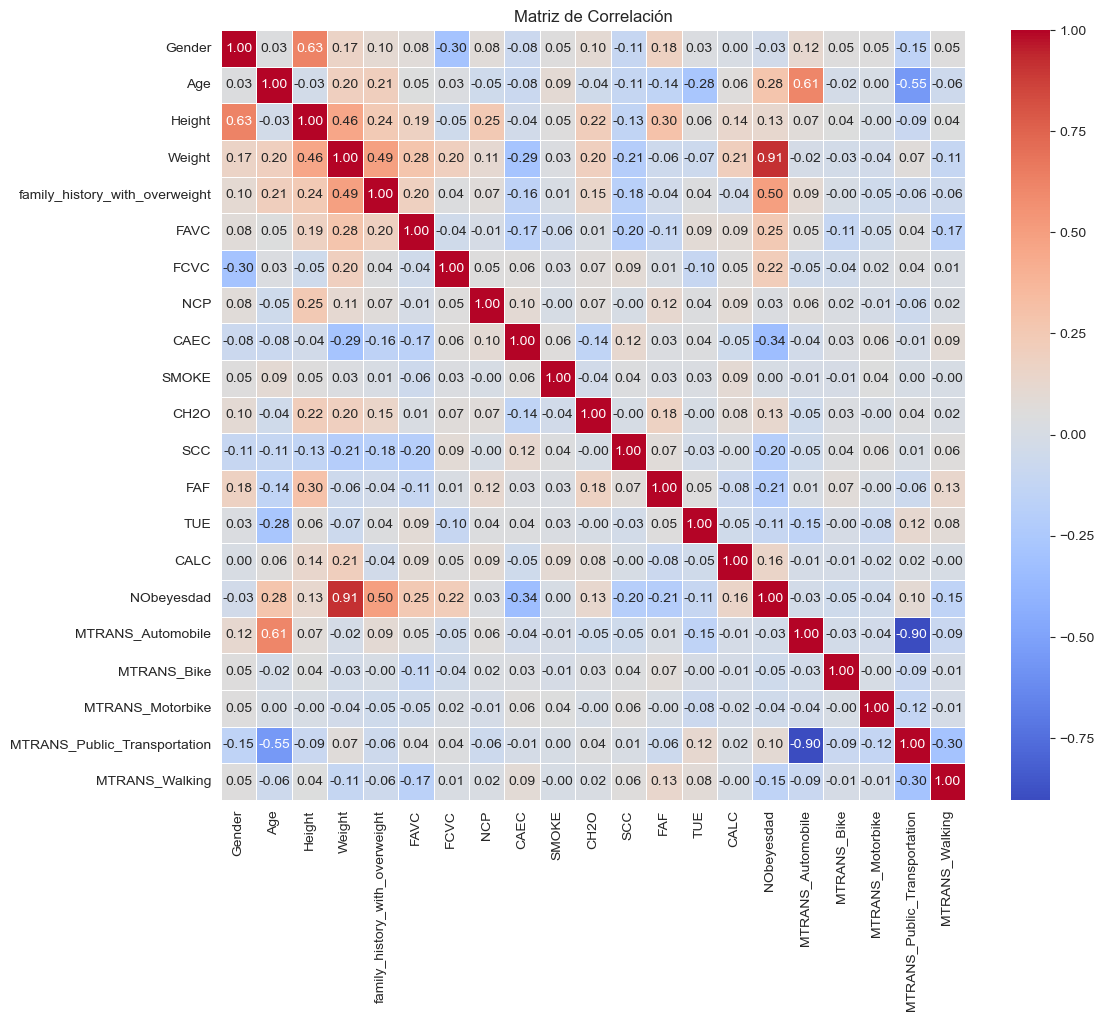

In [18]:
corr_matrix = df_split.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

Veiem que el pes té una correlació molt alta a la variable resposta. Cosa que té sentit ja que la classificació de NObeyesdad s'assigna de la segëunt manera segons el valor de BMI (body mass index):
- Underweight Less than 18.5
- Normal 18.5 to 24.9
- Overweight 25.0 to 29.9
- Obesity I 30.0 to 34.9
- Obesity II 35.0 to 39.9
- Obesity III Higher than 40

Per calcular el BMI: $ BMI = \frac{weight}{height^2}$. Veiem a la taula de correlacions que la variable Weight té molt de pes a la classificació del tipus d'obessitat, cosa que és obvia. Com el que volem és estudiar el pes que tenen la resta de variables no tant obvies, cosiderarem una nova base de dades que no tingui en compte la variable Height ni la variable Weight.

In [19]:
df_new= df_split.copy()
#borrem les variables pes i alçada
df_new= df_new.drop(columns=['Weight', 'Height'])
df_new.describe()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000
mean,0.510033,24.283944,0.822185,0.879599,2.426377,2.682923,1.145485,0.022297,2.016808,0.045708,1.016984,0.652431,0.732441,3.110925,0.215162,0.002787,0.005017,0.748606,0.028428
std,0.500039,6.339740,0.382463,0.325521,0.529187,0.777583,0.472931,0.147687,0.612781,0.208909,0.845354,0.601616,0.513929,1.984452,0.411049,0.052734,0.070671,0.433935,0.166239
min,0.000000,14.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.899719,1.000000,1.000000,2.000000,2.656871,1.000000,0.000000,1.607680,0.000000,0.131685,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,22.762612,1.000000,1.000000,2.398408,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.619850,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,26.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.499683,0.000000,1.674792,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,61.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


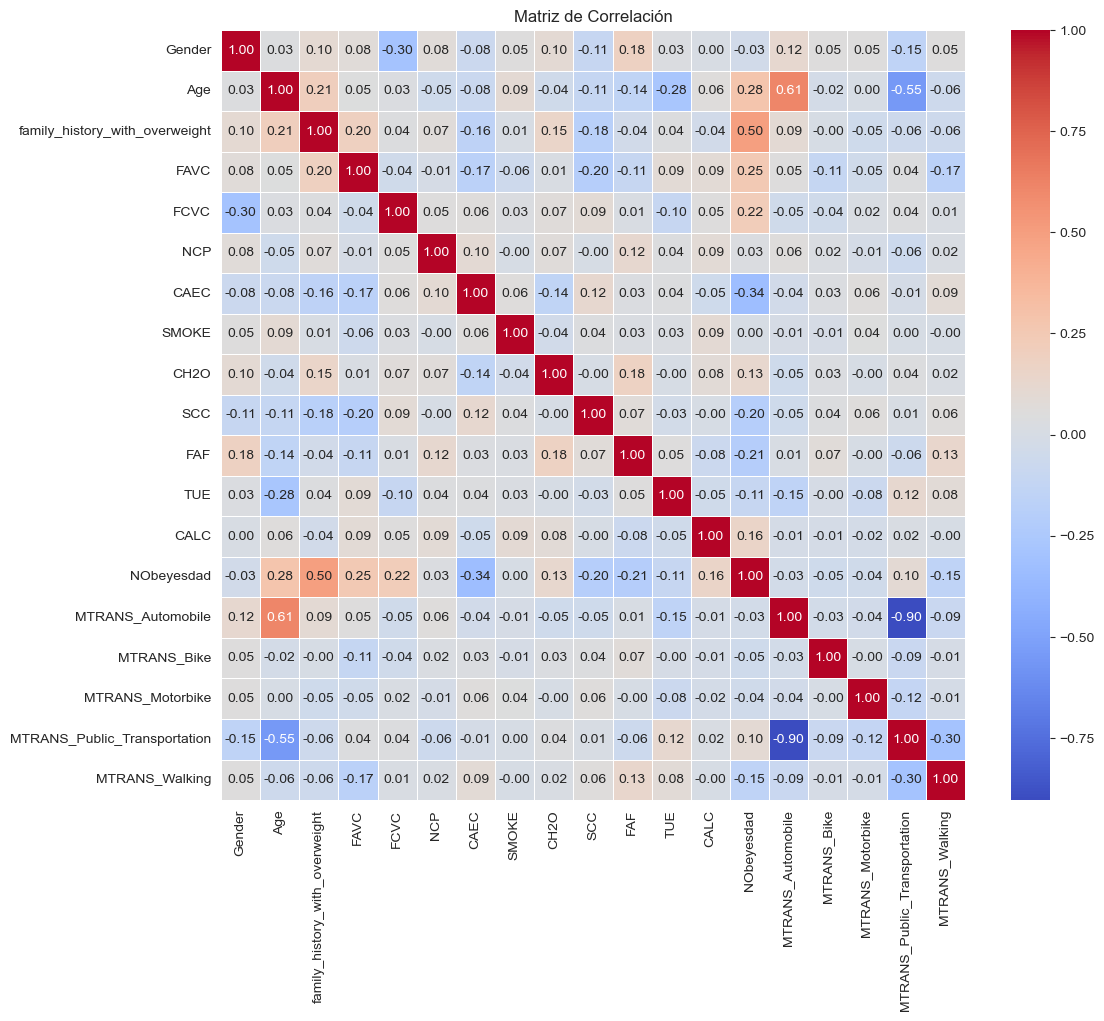

In [20]:
corr_matrix = df_new.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

(Cor)Relacions amb la variable NObeyesdad:
- Molt alta amb el pes. 
- Veiem que fumar no té correlació, podem treure la variable SMOKE. 
- L'historia de la familia té bastanta relació 
- La variable NCP té poc pes, haurem de mirar si volem eliminar-la.
- La variable transport(automobil) també té poc pes però està relacionada amb les altres de transport

Variables que estan correlaciones:
- Alçada amb el genere
- Alçada amb el pes
- PEs amb l'historial familiar
- Transport públic amb l'edat (invers)
- Automobil amb l'edat
- Transport públic amb l'automobil (invers)


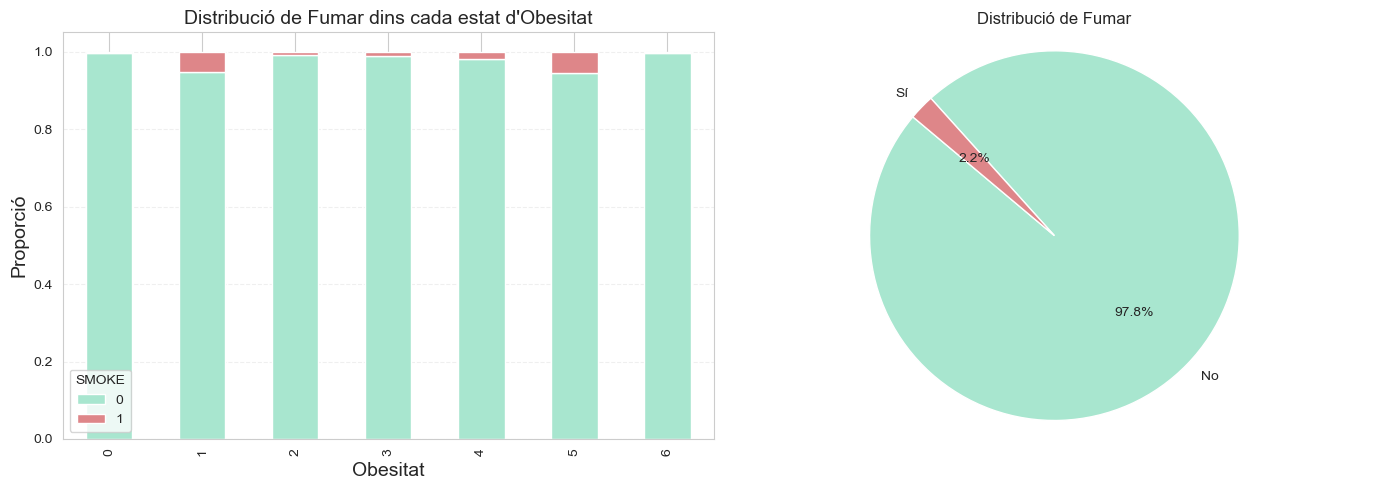

In [21]:
#Volem observar perq la variable smoke no te relacio amb l obesitat, potser que estigui desbalancejada --> per aixo és possible que no aporti info
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Gràfic 1: Distribució de fumar dins cada estat d'obesitat ---
ct_rev = pd.crosstab(df_new["NObeyesdad"], df_new['SMOKE'], normalize='index')

ct_rev.plot(kind='bar', stacked=True, color=['#A8E6CF',"#DE8689"], ax=axes[0])
axes[0].set_title('Distribució de Fumar dins cada estat d\'Obesitat', fontsize=14)
axes[0].set_xlabel('Obesitat', fontsize=14)
axes[0].set_ylabel('Proporció', fontsize=14)
axes[0].grid(alpha=0.3, axis='y', linestyle='--')

# --- Gràfic 2: Distribució global de fumadors ---
smoke_counts = df_new['SMOKE'].value_counts()

axes[1].pie(smoke_counts,
            labels=['No', 'Sí'],
            autopct='%1.1f%%',
            startangle=140,
            colors=['#A8E6CF',"#DE8689"])
axes[1].set_title('Distribució de Fumar')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

Eliminem la variable SMOKE

Age                               0.164326
FCVC                              0.141649
FAF                               0.094101
NCP                               0.092567
TUE                               0.090910
CH2O                              0.089867
Gender                            0.069250
CAEC                              0.058283
CALC                              0.055911
family_history_with_overweight    0.045515
FAVC                              0.026786
MTRANS_Public_Transportation      0.026010
MTRANS_Automobile                 0.021158
SCC                               0.012739
MTRANS_Walking                    0.006706
SMOKE                             0.003122
MTRANS_Motorbike                  0.000741
MTRANS_Bike                       0.000360
dtype: float64


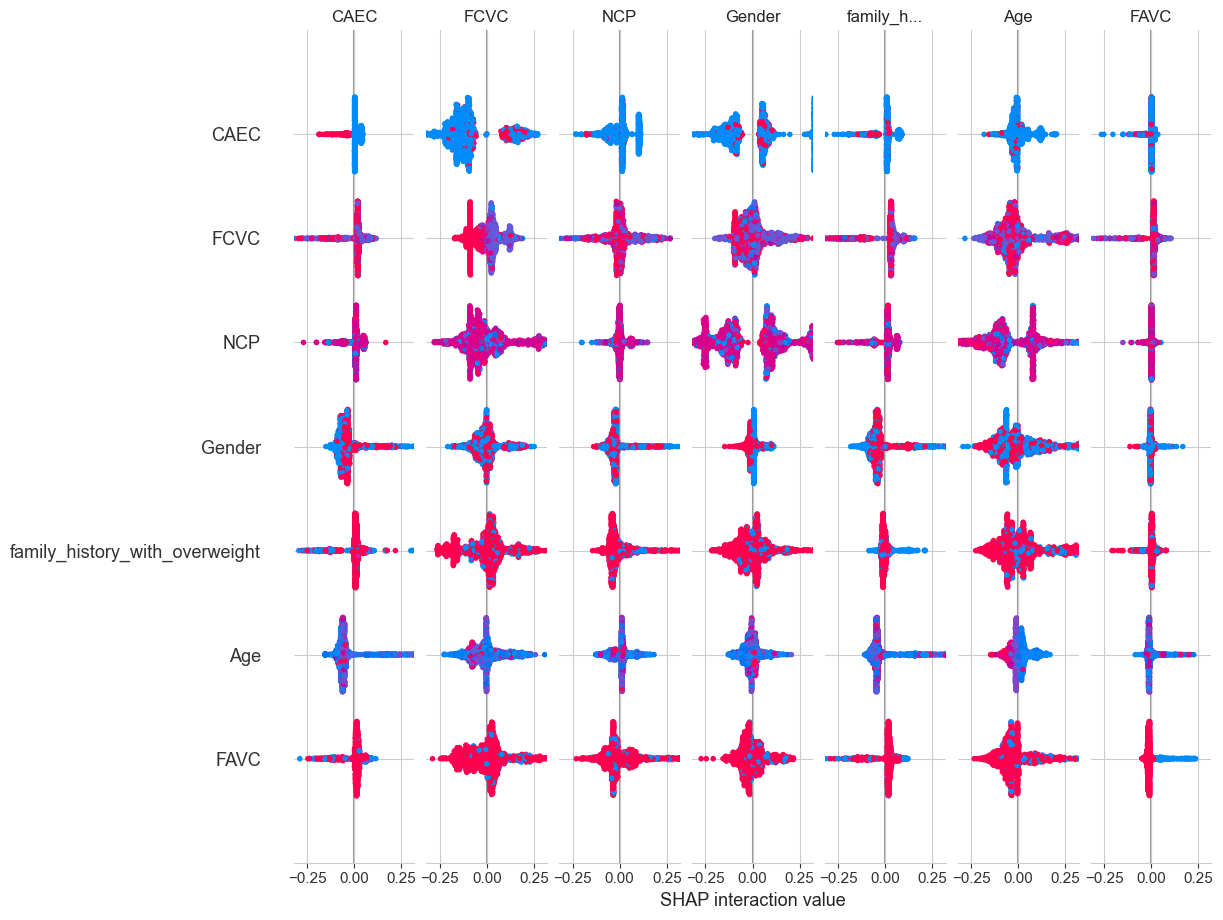

None


In [22]:
#provar la importacia de les variables, mirar altres formes de fer-ho
X = df_new[[c for c in df_new.columns if c != 'NObeyesdad']]
y = df_new['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
import pandas as pd

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False))
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)
print(shap.summary_plot(shap_values, X_train,max_display=10))

#Si vols selecció de variables fiable per prediccions, sobretot amb pocs features (21) i combinacions complexes → SHAP és millor.
#Random Forest feature importance està bé per un primer filtratge ràpid, però no és tan fiable com SHAP quan hi ha correlacions o interaccions.

#podem comparar entre no treure cap (smoke si), i treure totes les que no surten a shap

In [34]:
df_clean = df_new[[c for c in df_new.columns if c != 'SMOKE']]


Ja hem passat les variables a numeriques, veiem que podem eliminar smoke, fem normalització i mirem si podem eliminar alguna variable més

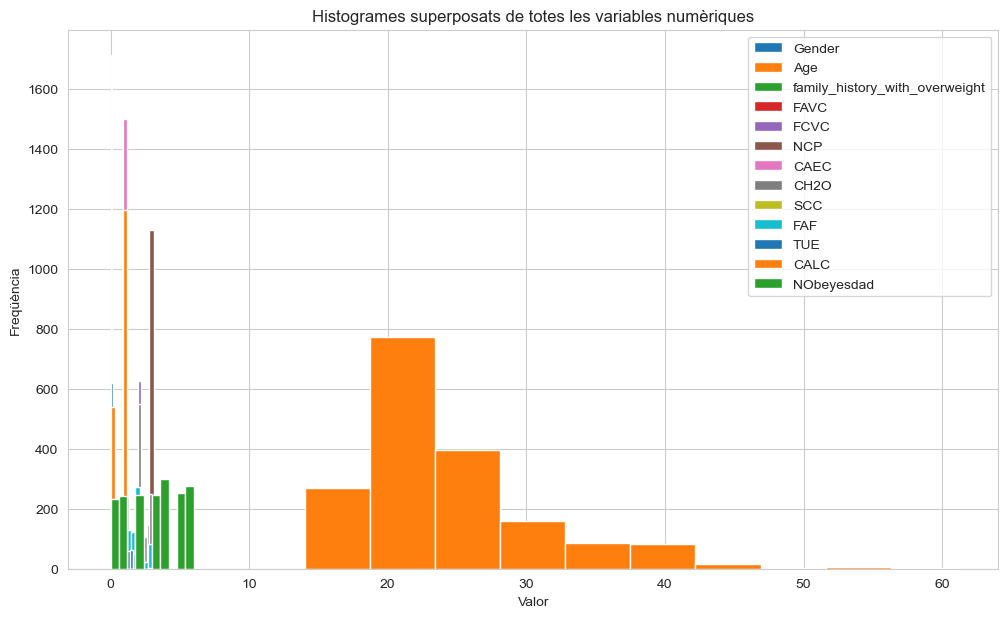

In [35]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Fem l'histograma superposat
plt.figure(figsize=(12, 7))

for col in numeric_cols:
    plt.hist(df_clean[col], bins=10, alpha=1, label=col)

plt.title("Histogrames superposats de totes les variables numèriques")
plt.xlabel("Valor")
plt.ylabel("Freqüència")
plt.legend(loc='upper right', fontsize=10)
plt.show()

La normalització la fem amb z-score.

C:\Users\natal\AppData\Local\Temp\ipykernel_32452\2226357634.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()


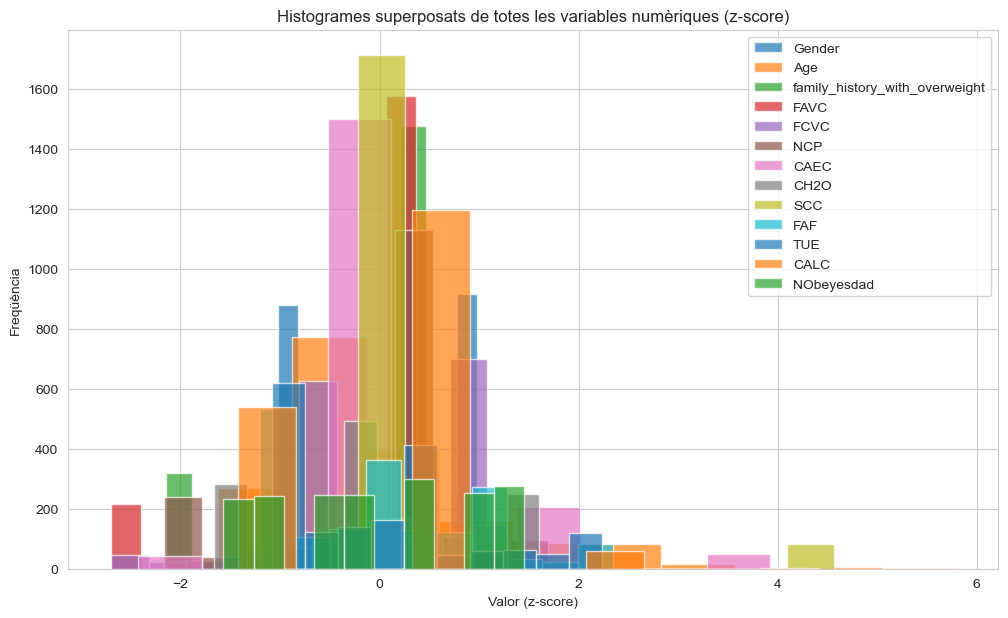

In [36]:
# Seleccionem només les columnes numèriques
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Transformem a z-score

for col in numeric_cols:
    df_clean[col] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()
    
# Fem l'histograma superposat
plt.figure(figsize=(12, 7))

for col in numeric_cols:
    plt.hist(df_clean[col], bins=10, alpha=0.7, label=col)  # alpha=0.5 per veure superposició

plt.title("Histogrames superposats de totes les variables numèriques (z-score)")
plt.xlabel("Valor (z-score)")
plt.ylabel("Freqüència")
plt.legend(loc='upper right', fontsize=10)
plt.show()


In [37]:
X = df_clean[[c for c in df_clean.columns if c != 'NObeyesdad']]
y = df_clean['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


Comprovem si cal eliminar alguna variable amb Lasso

In [38]:
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X, y)

coef = pd.Series(model_lasso.coef_, index=X.columns)
print("\nCoeficients del model LASSO:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model LASSO:


,Pes de la variable
family_history_with_overweight,0.340603
CAEC,-0.169662
FCVC,0.116535
Age,0.078337
FAF,-0.068407
FAVC,0.046790
CALC,0.039925
SCC,-0.008164
MTRANS_Automobile,-0.000000
MTRANS_Public_Transportation,0.000000


Lasso ens elimina la majoria de variables, només ens quedem amb Weight, Height, family_history_with_overweight. 

Potser Lasso no acaba de ser del tot eficient ja que tenim algunes variables altament correlacionades:
- MTRANS_Automobile - Age
- MTRANS_Public_Transportation - Age
- MTRANS_Automobile - MTRANS_Public_Transportation
- Hight - Gender


Provem de fer la selecció de variables amb Ridge

In [39]:
model_ridge = Ridge()
model_ridge.fit(X,y)

coef = pd.Series(model_ridge.coef_, index=X.columns)
print("\nCoeficients del model Ridge:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model Ridge:


,Pes de la variable
family_history_with_overweight,0.373127
MTRANS_Public_Transportation,0.322899
MTRANS_Automobile,-0.310369
Age,0.289778
CAEC,-0.230511
FCVC,0.195222
FAF,-0.118449
MTRANS_Walking,-0.112772
FAVC,0.102962
CALC,0.099348


Potser la millor opció és Elastic Net, un model que combina la regulartizació de Lasso i la Regularització de Ridge

In [40]:
model_en = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_en.fit(X,y)

coef = pd.Series(model_en.coef_, index=X.columns)
print("\nCoeficients del model ElasticNet:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model ElasticNet:


,Pes de la variable
family_history_with_overweight,0.348398
CAEC,-0.194379
FCVC,0.157962
Age,0.125711
MTRANS_Public_Transportation,0.096382
FAF,-0.095769
CALC,0.074309
FAVC,0.073450
SCC,-0.043777
TUE,-0.013461


In [41]:
df_reduit = df_clean[['family_history_with_overweight', 'FCVC', 'FAF', 'Age', 'CAEC', 'FAVC', 'CALC', 'SCC', 'NObeyesdad']]

In [42]:
X_red = df_reduit[[c for c in df_reduit.columns if c != 'NObeyesdad']]
y_red = df_reduit['NObeyesdad']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.2, random_state=42) #ara si que fem x test amb el t


## Metric selection
Hem de triar una mètrica per comparar models:
- R²: compara la variància total de la variable dependent amb la variància que el model no ha pogut explicar, si el model te poca variancia, surt un r2 baix i potser molt bo i fa creure que el model no generalitza, tot i que sí ho fa.
- MAE (el que utlitzarem): Serveix per mesurar com d’equivocat està un model, de mitjana, sense exagerar els errors grans.si la MAE és baixa el model és millor.
- RMSE: mesura com s’equivoca el model però penalitzant més fortament els errors grans (eleva els errors al quadrat).
És útil si volem posar més pes als casos on la predicció falla molt. Si n'hi un de molt gran la metrica li dona molt de pes. (dubto amb aquest)

De moment utilitzem RMSE, penalitza els errors més grans

## Model selection

Algoritmes que utilitzarem:
- Regressió lineal.
- Random Forest
- Gradient boosting (XGBoost,LightGBM)
- SVR

In [46]:
lr = LinearRegression()
ypred_lr = lr.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_lr), np.sqrt(mean_squared_error(y_test, ypred_lr))


(0.6115881436552384, 0.7334603258830072)

In [47]:
dt = DecisionTreeRegressor() #el millor mae
ypred_dt= dt.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_dt), np.sqrt(mean_squared_error(y_test, ypred_dt))


(0.3581696732244705, 0.6994702350216137)

In [48]:
lgb = LGBMRegressor() 
ypred_lgb=lgb.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_lgb), np.sqrt(mean_squared_error(y_test, ypred_lgb))

c:\Users\natal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\natal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 1435, number of used features: 8
[LightGBM] [Info] Start training from score 0.006961


(0.3539866820661385, 0.549371517117132)

In [49]:
svr = SVR()  # C=1.0, epsilon=0.1, kernel='rbf
ypred_svr=svr.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_svr), np.sqrt(mean_squared_error(y_test, ypred_svr))

(0.4205473455353456, 0.6490840379682347)

In [50]:
xgb = XGBRegressor() #objective='reg:absoluteerror', n_estimators=100, learning_rate=0.1 #el millor rmse
ypred_xgb=xgb.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_xgb), np.sqrt(mean_squared_error(y_test, ypred_xgb))

(0.3635905289369289, 0.5680212667283125)

### Regressió logística

In [51]:
model_reduit = LinearRegression().fit(X_train, y_train)

In [52]:
y_pred = model_reduit.predict(X_test)

In [53]:
mse = mean_squared_error(y_test, y_pred)
mse

0.5379640496444071

In [54]:
np.sqrt(mse)

0.7334603258830072

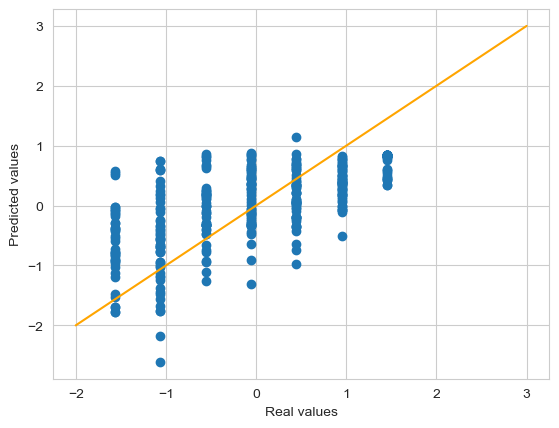

In [55]:
plt.scatter(y_test, y_pred)
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.plot([-2, 3], [-2, 3], c="orange")
plt.show()

Aquest gràfic demostra que la nostra variable resposta no és una escala de regressió lineal contínua, sinó una sèrie de categories que hem tractat com a números. 

Fem les últimes comprovacions per veure que el nostre dataset no te bon rendiment amb regressió lineal.

In [56]:
y_pred_discret = np.round(y_pred)
y_test_discret = np.clip(y_test, a_min = 0, a_max = 6)
y_test_discret = np.round(y_test_discret)

### Coeficient de determinació (R^2)

In [57]:
r2 = r2_score(y_test_discret, y_pred_discret)
print("R-squared:", r2)

R-squared: -1.7444787644787643


Aquesta metrica mesura la proporció de variancia en la variable independent. Com més a prop de 1 sigui, millor s'adaptarà el model a les dades. Tenim un valor negatiu, és molt mal rendiment. 

### Mean square error (MSE)

In [58]:
mse = mean_squared_error(y_test_discret, y_pred_discret)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.5515320334261838


Mesura la precisió de les prediccions del model

### Mean absolut error (MAE)

In [59]:
mae = np.mean(np.abs(y_test_discret - y_pred_discret))
print("Mean Absolut Error:", mae)

Mean Absolut Error: 0.4735376044568245


### Root mean squared error (RMSE)

In [60]:
rmse = np.sqrt(mean_squared_error(y_test_discret, y_pred_discret))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.7426520271474278
